In [198]:
from pathlib import Path
import meshio
from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu,  accessing_mesh_data, create_mock_mesh
import torch

In [199]:
folder_path = Path("../IDSC2025_AnXplore03")

xdmf_files = list(folder_path.rglob("*.xdmf"))
xdmf_files = [str(x) for x in xdmf_files]
xdmf_file_path = xdmf_files[2]

In [200]:
meshes = xdmf_to_meshes(xdmf_file_path)
data_mesh = accessing_mesh_data(meshes[0])
data_mesh

Loaded 80 timesteps from ..\IDSC2025_AnXplore03\4Students_AnXplore03\AllFields_Resultats_MESH_117.xdmf

There are 16634 nodes in this mesh.
First 5 nodes of the mesh: 
[[0.1255755  4.570036   1.235219  ]
 [0.39698863 4.5739017  1.2614987 ]
 [0.6789052  4.4941964  1.2035406 ]
 [0.9398925  4.381488   1.1121883 ]
 [1.2186548  4.293917   1.0842079 ]] 

Types of cells in the mesh: ['tetra']
There are 82564 tetrahedral cells in this mesh.
First 5 tetrahedral cells of the mesh: 
[[6449 6450 6451 6452]
 [6453 6454 6455 3295]
 [6456 6457 6458 6459]
 [6460 6461 6462 6463]
 [6464 4622 4617 3869]] 

Feature name: Vitesse / Feature shape: (16634, 3)
Feature name: Pression / Feature shape: (16634,)


In [201]:
mesh = meshes[0]
nodes_xyz = mesh.points
nodes_v = mesh.point_data["Vitesse"]
nodes_P = mesh.point_data["Pression"]
tetras = mesh.cells_dict["tetra"]
N = nodes_xyz.shape[0]

In [202]:
import networkx as nx

G = nx.Graph()

for i, node in enumerate(nodes_xyz):
    attrs = {"pos": nodes_xyz[i], "v": nodes_v[i], "P": nodes_P[i]}
    G.add_node(i, **attrs)

for tetra in tetras:
    for i in range(len(tetra)):
        for j in range(i + 1, len(tetra)):
            G.add_edge(tetra[i], tetra[j])

In [203]:
def graph_from_mesh(mesh : meshio.Mesh) -> nx.Graph:
    nodes_xyz = mesh.points
    nodes_v = mesh.point_data["Vitesse"]
    nodes_P = mesh.point_data["Pression"]
    tetras = mesh.cells_dict["tetra"]
    N = nodes_xyz.shape[0]
    G = nx.Graph()
    for i, node in enumerate(nodes_xyz):
        attrs = {"pos": nodes_xyz[i], "v": nodes_v[i], "P": nodes_P[i]}
        G.add_node(i, **attrs)
    for tetra in tetras:
        for i in range(len(tetra)):
            for j in range(i + 1, len(tetra)):
                G.add_edge(tetra[i], tetra[j])
    return G

In [ ]:
import numpy as np

def nodes_summary(mesh : meshio.Mesh) -> np.ndarray:
    nodes_xyz = torch.tensor(mesh.points, dtype=torch.float32)
    nodes_v = torch.tensor(mesh.point_data["Vitesse"], dtype=torch.float32)
    nodes_P = torch.tensor(mesh.point_data["Pression"], dtype=torch.float32)
    tetras = torch.tensor(mesh.cells_dict["tetra"], dtype=torch.int32)
    nodes_all = torch.cat((nodes_xyz, nodes_v, nodes_P), dim=1)
    return nodes_all

def nodes_edges_from_mesh(mesh : meshio.Mesh) -> list[np.ndarray, np.ndarray]:
    nodes_xyz = mesh.points
    nodes_v = mesh.point_data["Vitesse"]
    nodes_P = mesh.point_data["Pression"]
    tetras = mesh.cells_dict["tetra"]
    nodes_xyz = torch.tensor(mesh.points, dtype=torch.float32)
    nodes_v = torch.tensor(mesh.point_data["Vitesse"], dtype=torch.float32)
    nodes_P = torch.tensor(mesh.point_data["Pression"], dtype=torch.float32)
    tetras = torch.tensor(mesh.cells_dict["tetra"], dtype=torch.int32)
    nodes_all = torch.cat((nodes_xyz, nodes_v, nodes_P), dim=1)
    edges_set = set()
    for tetra in tetras:
        for i in range(len(tetra)):
            for j in range(i + 1, len(tetra)):
                edge = tuple(sorted((tetra[i], tetra[j])))
                edges_set.add(edge)
    edges = torch.tensor(list(edges_set), dtype=torch.int32).t()
    return nodes_all, edges

In [197]:
import numpy as np

def nodes_summary(mesh : meshio.Mesh) -> np.ndarray:
    nodes_xyz = mesh.points
    nodes_v = mesh.point_data["Vitesse"]
    nodes_P = mesh.point_data["Pression"]
    tetras = mesh.cells_dict["tetra"]
    nodes_all = np.hstack((nodes_xyz, nodes_v, np.expand_dims(nodes_P, axis=1)))
    return nodes_all

In [172]:
degrees = [G.degree[i] for i in G.nodes]

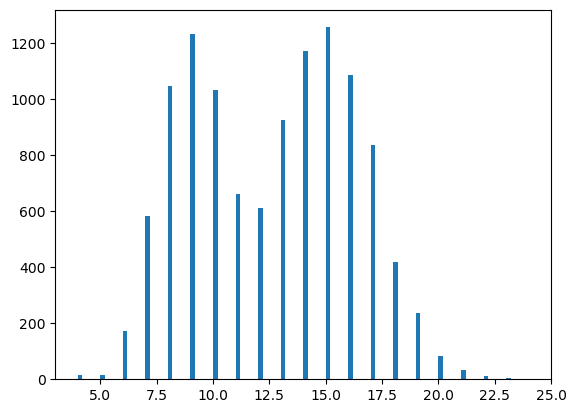

In [180]:
import matplotlib.pyplot as plt
plt.hist(degrees, bins=100);

In [186]:
list(G.neighbors(0))

[4807, 2921, 2922, 2676, 5404, 5231, 76, 726, 1]

In [184]:
G.nodes[0]

{'pos': array([-2.205367,  4.560882,  1.67214 ], dtype=float32),
 'v': array([ 2.8116127e-13, -1.7383845e-14, -7.7049132e-14], dtype=float32),
 'P': 169.13710021972656}